# Exercises 03 Answers: Deep Learning

### Important Note: Enabling GPU
To make sure this is enabled, go to the "Runtime" menu at the top of the page, and click select the "Change Runtime Type" option. Under "Hardware Accelerator", choose "GPU" and then hit "Save". 

## Exercise 1

#################################
# Input:
Images is tensor of shape: torch.Size([64, 1, 28, 28]), labels is tensor of shape: torch.Size([64])
Images:


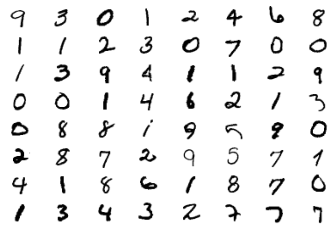

Labels:
9,3,0,1,2,4,6,8,
1,1,2,3,0,7,0,0,
1,3,9,4,1,1,2,9,
0,0,1,4,6,2,1,3,
0,8,8,1,9,5,9,0,
2,8,7,2,9,5,7,1,
4,1,8,6,1,8,7,0,
1,3,4,3,2,7,7,7,
#################################
# Training:
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.299167
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.373792
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.232981
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.291982
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.109752
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.177762
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.089174
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.105035
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.123869
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.171569

Test set: Average loss: 896.4842, Accuracy: 9734/10000 (97%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


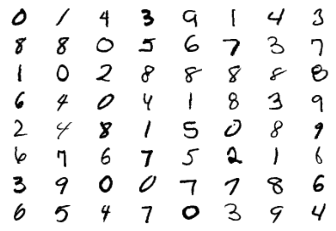

Preds:
0,1,4,3,9,1,4,3,
8,8,0,5,6,7,3,7,
1,0,2,8,8,8,8,0,
6,4,0,4,1,8,3,9,
2,4,8,1,5,0,8,9,
6,7,6,7,5,2,1,6,
3,9,0,0,7,7,8,6,
6,5,4,7,0,3,9,4,


In [1]:
import itertools

import argparse
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

BATCH_SIZE = 64
TEST_BATCH_SIZE = 1000
#LEARNING_RATE = 1
LEARNING_RATE = 0.001 # CHANGED
GAMMA = 0.7
RANDOM_SEED = 1

torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda")

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True, num_workers=1, pin_memory=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=TEST_BATCH_SIZE, shuffle=True, num_workers=1, pin_memory=True)

print("#################################")
print("# Input:")

train_iter = iter(train_loader)
test_iter = iter(test_loader)
images, labels = train_iter.next()
print(f'Images is tensor of shape: {images.shape}, labels is tensor of shape: {labels.shape}')
figure = plt.figure()
num_of_images = 64
for index in range(1, num_of_images + 1):
    plt.subplot(8, 8, index)
    plt.axis('off')
    plt.imshow(images[index-1].numpy().squeeze(), cmap='gray_r')
print("Images:")
plt.show()
print("Labels:")
for i in range(8):
    for j in range(8):
        print(labels[i*8+j].item(), end=',')
    print()

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

model = Model().to(device)
#optimizer = optim.Adadelta(model.parameters(), lr=LEARNING_RATE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)  # Changed


EPOCHS = 1
ITER_PER_EPOCH = 1000
TEST_ITER_PER_EPOCH = len(test_loader)
LOG_INTERVAL = 100

print("#################################")
print("# Training:")

for epoch in range(EPOCHS):
    train_iter = itertools.cycle(iter(train_loader))
    test_iter =  iter(test_loader)

    for batch_idx in range(ITER_PER_EPOCH):
        (data, target) = next(train_iter)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    test_loss = 0
    total = 0
    correct = 0
    images = None
    preds = None
    with torch.no_grad():
        for batch_idx in range(TEST_ITER_PER_EPOCH):
            (data, target) = next(test_iter)

            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += data.shape[0]
            images = data.cpu()
            preds = pred.cpu().numpy()
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, total,
            100. * correct / total))

    print(f'Images is tensor of shape: {images.shape}, preds is tensor of shape: {preds.shape}')
    figure = plt.figure()
    num_of_images = 64
    for index in range(num_of_images):
        plt.subplot(8, 8, index+1)
        plt.axis('off')
        plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')
    
    print("#################################")
    print("# Test Output:")

    print("Images:")
    plt.show()
    print("Preds:")
    for i in range(8):
        for j in range(8):
            print(preds[i*8+j].item(), end=',')
        print()

## Exercise 02:

#################################
# Input:
Images is tensor of shape: torch.Size([64, 1, 28, 28]), labels is tensor of shape: torch.Size([64])
Images:


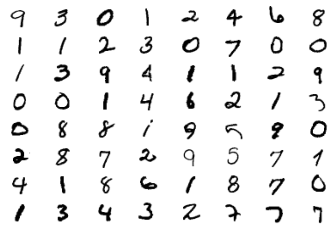

Labels:
9,3,0,1,2,4,6,8,
1,1,2,3,0,7,0,0,
1,3,9,4,1,1,2,9,
0,0,1,4,6,2,1,3,
0,8,8,1,9,5,9,0,
2,8,7,2,9,5,7,1,
4,1,8,6,1,8,7,0,
1,3,4,3,2,7,7,7,
#################################
# Training:
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.299167
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.374684
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.242828
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.315691
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.094607
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.180018
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.102169
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.076862
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.095444
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.194605

Test set: Average loss: 859.9913, Accuracy: 9767/10000 (98%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


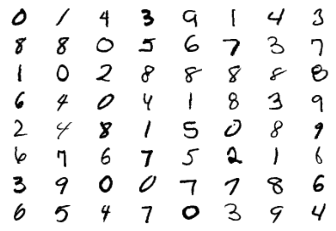

Preds:
0,1,4,3,9,1,4,3,
8,8,0,5,6,7,3,7,
1,0,2,8,8,8,8,0,
6,4,0,4,1,8,3,9,
2,4,8,1,5,0,8,9,
6,7,6,7,5,2,1,6,
3,9,0,0,7,7,8,6,
6,5,4,7,0,3,9,4,
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.021241
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.011450
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.070811
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.050774
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.049331
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.044899
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.143091
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.035558
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.032942
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.072654

Test set: Average loss: 790.4579, Accuracy: 9781/10000 (98%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


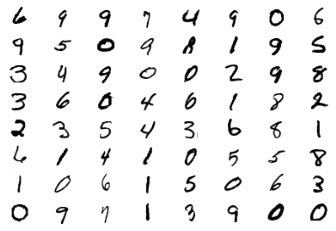

Preds:
6,9,9,7,4,9,0,6,
9,5,0,9,8,1,9,5,
3,4,9,0,0,2,9,8,
3,6,0,4,0,1,8,2,
2,3,5,4,3,6,8,1,
6,1,4,1,0,5,5,8,
1,0,6,1,5,0,6,3,
0,9,7,1,3,9,0,0,
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.017514
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.217173
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.147131
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.057066
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.074456
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.047673
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.024686
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.093247
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.012663
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.010074

Test set: Average loss: 631.6107, Accuracy: 9808/10000 (98%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


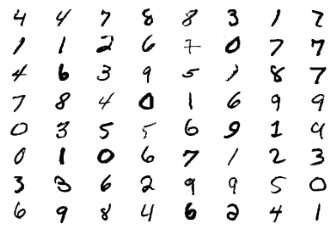

Preds:
4,4,7,8,8,3,1,7,
1,1,2,6,7,0,7,7,
4,6,3,9,5,2,8,7,
7,8,4,0,1,6,9,9,
0,3,5,5,6,9,1,9,
0,1,0,6,7,1,2,3,
3,3,6,2,9,9,5,0,
6,9,8,4,6,2,4,1,
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.065600
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.037452
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.206625
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.044969
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.019844
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.014025
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.045393
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.007675
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.023994
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.006118

Test set: Average loss: 770.9639, Accuracy: 9788/10000 (98%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


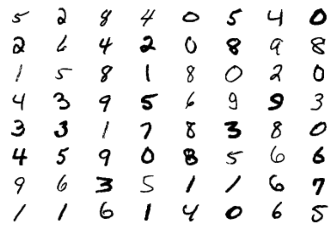

Preds:
5,2,8,4,0,5,4,0,
2,6,4,2,0,8,9,8,
1,5,8,1,8,0,2,0,
4,3,9,5,6,9,9,3,
3,3,1,7,8,3,8,0,
4,5,9,0,8,5,6,6,
9,6,3,5,1,1,6,7,
1,1,6,1,4,0,6,5,
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.031032
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.008077
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.066312
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.087207
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.023240
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.060541
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.060745
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.058717
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.005599
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.009072

Test set: Average loss: 649.0346, Accuracy: 9826/10000 (98%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


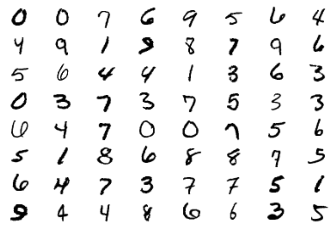

Preds:
0,0,7,6,9,5,0,4,
4,9,1,8,8,7,9,6,
5,6,4,4,1,3,6,3,
0,3,7,3,7,5,3,3,
0,4,7,0,0,7,5,6,
5,1,8,6,8,8,7,5,
6,4,7,3,7,7,5,1,
8,4,4,8,6,6,3,5,
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.011551
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.025807
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.008428
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.003176
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.022702
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.007658
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.417404
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.052243
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.031665
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.002247

Test set: Average loss: 626.1129, Accuracy: 9827/10000 (98%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


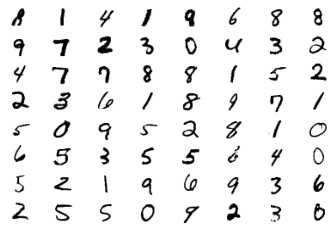

Preds:
8,1,4,1,9,6,8,8,
9,7,2,3,0,4,3,2,
4,7,7,8,8,1,5,2,
2,3,6,1,8,9,7,1,
5,0,9,5,2,8,1,0,
6,5,3,5,5,6,4,0,
5,2,1,9,6,9,3,6,
2,5,5,0,9,2,3,0,
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.046828
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.030437
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.009052
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.038065
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.040720
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.006606
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.043786
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.012909
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.033843
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.009095

Test set: Average loss: 536.3994, Accuracy: 9848/10000 (98%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


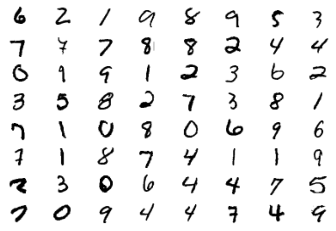

Preds:
6,2,1,9,8,9,5,3,
7,7,7,8,8,2,4,4,
0,9,9,1,2,3,6,2,
3,5,8,2,7,3,8,1,
7,1,0,8,0,6,9,6,
7,1,8,7,4,1,1,9,
7,3,0,6,4,4,7,5,
7,0,9,4,4,7,4,9,
Train Epoch: 7 [0/60000 (0%)]	Loss: 0.006831
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.002790
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.021802
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.005880
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.007426
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.047933
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.071449
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.017677
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.004282
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.059183

Test set: Average loss: 677.4011, Accuracy: 9822/10000 (98%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


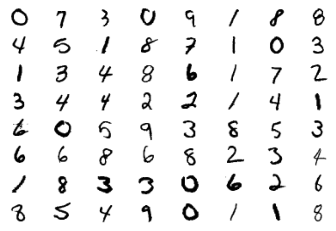

Preds:
0,7,3,0,9,1,8,8,
4,5,1,8,7,1,0,3,
1,3,4,8,6,1,7,2,
3,4,4,2,2,1,4,1,
6,0,5,9,3,8,5,3,
6,6,8,6,8,2,3,4,
1,8,3,3,0,6,2,6,
8,5,4,9,0,1,1,8,
Train Epoch: 8 [0/60000 (0%)]	Loss: 0.029880
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.046370
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.002718
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.036198
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.001419
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.001936
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.072880
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.030453
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.006239
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.042415

Test set: Average loss: 617.6701, Accuracy: 9838/10000 (98%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


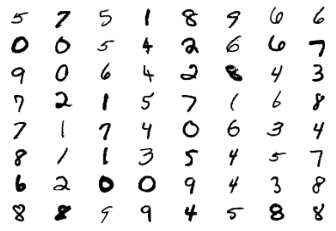

Preds:
5,7,5,1,8,9,6,6,
0,0,5,4,2,6,6,7,
9,0,6,4,2,8,4,3,
7,2,1,5,7,1,6,8,
7,1,7,4,0,6,3,4,
8,1,1,3,5,4,5,7,
6,2,0,0,9,4,3,8,
8,8,9,9,4,5,8,8,
Train Epoch: 9 [0/60000 (0%)]	Loss: 0.015500
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.117036
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.002190
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.002718
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.000281
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.005671
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.018884
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.013759
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.063679
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.001584

Test set: Average loss: 629.0369, Accuracy: 9842/10000 (98%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


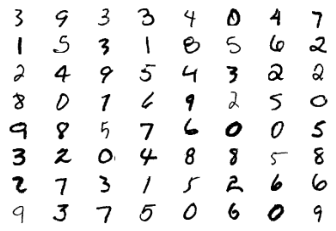

Preds:
3,9,3,3,4,0,4,7,
1,5,3,1,8,5,6,2,
2,4,9,5,4,3,2,2,
8,0,1,6,9,2,5,0,
9,8,5,7,6,0,0,5,
3,2,0,4,8,8,5,8,
2,7,3,1,5,2,6,6,
9,3,7,5,0,6,0,9,


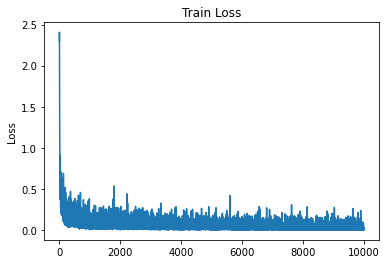

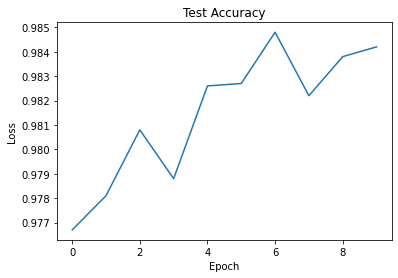

In [2]:
import itertools

import argparse
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

BATCH_SIZE = 64
TEST_BATCH_SIZE = 1000
#LEARNING_RATE = 1
LEARNING_RATE = 0.001 # CHANGED
GAMMA = 0.7
RANDOM_SEED = 1

torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda")

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True, num_workers=1, pin_memory=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=TEST_BATCH_SIZE, shuffle=True, num_workers=1, pin_memory=True)

print("#################################")
print("# Input:")

train_iter = iter(train_loader)
test_iter = iter(test_loader)
images, labels = train_iter.next()
print(f'Images is tensor of shape: {images.shape}, labels is tensor of shape: {labels.shape}')
figure = plt.figure()
num_of_images = 64
for index in range(1, num_of_images + 1):
    plt.subplot(8, 8, index)
    plt.axis('off')
    plt.imshow(images[index-1].numpy().squeeze(), cmap='gray_r')
print("Images:")
plt.show()
print("Labels:")
for i in range(8):
    for j in range(8):
        print(labels[i*8+j].item(), end=',')
    print()

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

model = Model().to(device)
#optimizer = optim.Adadelta(model.parameters(), lr=LEARNING_RATE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)  # Changed


EPOCHS = 10
ITER_PER_EPOCH = 1000
TEST_ITER_PER_EPOCH = len(test_loader)
LOG_INTERVAL = 100

print("#################################")
print("# Training:")

train_losses = []
test_accuracies = []

for epoch in range(EPOCHS):
    train_iter = itertools.cycle(iter(train_loader))
    test_iter =  iter(test_loader)
    
    train_losses_per_epoch = np.zeros(ITER_PER_EPOCH)
    for batch_idx in range(ITER_PER_EPOCH):
        (data, target) = next(train_iter)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    train_losses.append(train_losses_per_epoch.mean())
    test_loss = 0
    total = 0
    correct = 0
    images = None
    preds = None
    with torch.no_grad():
        for batch_idx in range(TEST_ITER_PER_EPOCH):
            (data, target) = next(test_iter)

            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += data.shape[0]
            images = data.cpu()
            preds = pred.cpu().numpy()
        test_accuracies.append(correct / total)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, total,
            100. * correct / total))
        
    print(f'Images is tensor of shape: {images.shape}, preds is tensor of shape: {preds.shape}')
    figure = plt.figure()
    num_of_images = 64
    for index in range(num_of_images):
        plt.subplot(8, 8, index+1)
        plt.axis('off')
        plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')
    
    print("#################################")
    print("# Test Output:")

    print("Images:")
    plt.show()
    print("Preds:")
    for i in range(8):
        for j in range(8):
            print(preds[i*8+j].item(), end=',')
        print()
plt.plot(train_losses)
plt.ylabel('Loss')
plt.title('Train Loss')
plt.show()

plt.plot(test_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Accuracy')
plt.show()

## Exercise 03:

## Increasing Dropout
Results are too noisy and it fails to learn anything at all.

#################################
# Input:
Images is tensor of shape: torch.Size([64, 1, 28, 28]), labels is tensor of shape: torch.Size([64])
Images:


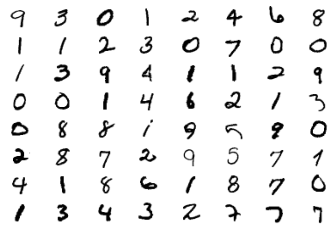

Labels:
9,3,0,1,2,4,6,8,
1,1,2,3,0,7,0,0,
1,3,9,4,1,1,2,9,
0,0,1,4,6,2,1,3,
0,8,8,1,9,5,9,0,
2,8,7,2,9,5,7,1,
4,1,8,6,1,8,7,0,
1,3,4,3,2,7,7,7,
#################################
# Training:
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.299917
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.300696
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.299616
Train Epoch: 0 [19200/60000 (32%)]	Loss: 2.305050
Train Epoch: 0 [25600/60000 (43%)]	Loss: 2.288922
Train Epoch: 0 [32000/60000 (53%)]	Loss: 2.298429
Train Epoch: 0 [38400/60000 (64%)]	Loss: 2.291141
Train Epoch: 0 [44800/60000 (75%)]	Loss: 2.301020
Train Epoch: 0 [51200/60000 (85%)]	Loss: 2.298804
Train Epoch: 0 [57600/60000 (96%)]	Loss: 2.296535

Test set: Average loss: 23009.8457, Accuracy: 1135/10000 (11%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


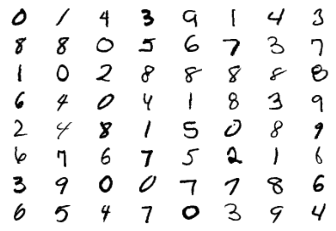

Preds:
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.297082
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.306136
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.304607
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.293906
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.306758
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.304788
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.305722
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.296390
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.295220
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.307646

Test set: Average loss: 23011.0569, Accuracy: 1135/10000 (11%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


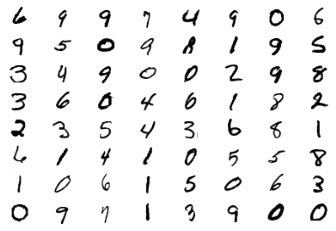

Preds:
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
Train Epoch: 2 [0/60000 (0%)]	Loss: 2.296305
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.305427
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.297406
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.290376
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.303162
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.307770
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.292444
Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.287831
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.305775
Train Epoch: 2 [57600/60000 (96%)]	Loss: 2.300337

Test set: Average loss: 23011.3665, Accuracy: 1135/10000 (11%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


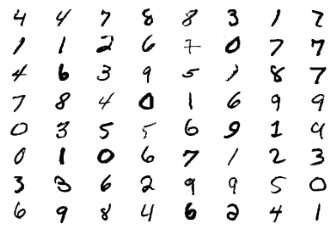

Preds:
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
Train Epoch: 3 [0/60000 (0%)]	Loss: 2.299839
Train Epoch: 3 [6400/60000 (11%)]	Loss: 2.297748
Train Epoch: 3 [12800/60000 (21%)]	Loss: 2.298100
Train Epoch: 3 [19200/60000 (32%)]	Loss: 2.295911
Train Epoch: 3 [25600/60000 (43%)]	Loss: 2.298463
Train Epoch: 3 [32000/60000 (53%)]	Loss: 2.315792
Train Epoch: 3 [38400/60000 (64%)]	Loss: 2.311137
Train Epoch: 3 [44800/60000 (75%)]	Loss: 2.298422
Train Epoch: 3 [51200/60000 (85%)]	Loss: 2.306098
Train Epoch: 3 [57600/60000 (96%)]	Loss: 2.297260

Test set: Average loss: 23010.8396, Accuracy: 1135/10000 (11%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


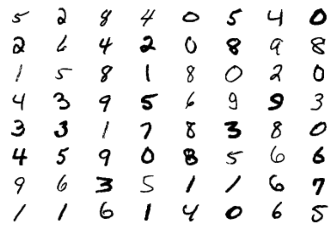

Preds:
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
Train Epoch: 4 [0/60000 (0%)]	Loss: 2.299304
Train Epoch: 4 [6400/60000 (11%)]	Loss: 2.298475
Train Epoch: 4 [12800/60000 (21%)]	Loss: 2.290417
Train Epoch: 4 [19200/60000 (32%)]	Loss: 2.301128
Train Epoch: 4 [25600/60000 (43%)]	Loss: 2.300173
Train Epoch: 4 [32000/60000 (53%)]	Loss: 2.302722
Train Epoch: 4 [38400/60000 (64%)]	Loss: 2.283738
Train Epoch: 4 [44800/60000 (75%)]	Loss: 2.301542
Train Epoch: 4 [51200/60000 (85%)]	Loss: 2.294651
Train Epoch: 4 [57600/60000 (96%)]	Loss: 2.288509

Test set: Average loss: 23011.0117, Accuracy: 1135/10000 (11%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


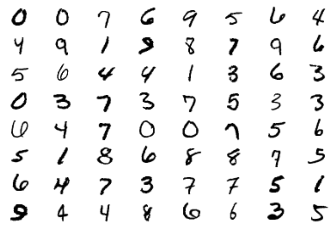

Preds:
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
Train Epoch: 5 [0/60000 (0%)]	Loss: 2.304637
Train Epoch: 5 [6400/60000 (11%)]	Loss: 2.311639
Train Epoch: 5 [12800/60000 (21%)]	Loss: 2.309575
Train Epoch: 5 [19200/60000 (32%)]	Loss: 2.293053
Train Epoch: 5 [25600/60000 (43%)]	Loss: 2.307488
Train Epoch: 5 [32000/60000 (53%)]	Loss: 2.297432
Train Epoch: 5 [38400/60000 (64%)]	Loss: 2.300417
Train Epoch: 5 [44800/60000 (75%)]	Loss: 2.310359
Train Epoch: 5 [51200/60000 (85%)]	Loss: 2.296351
Train Epoch: 5 [57600/60000 (96%)]	Loss: 2.295130

Test set: Average loss: 23010.2705, Accuracy: 1135/10000 (11%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


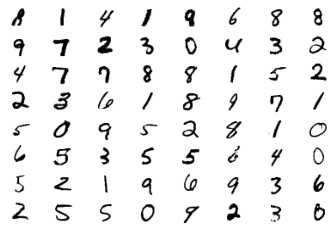

Preds:
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
Train Epoch: 6 [0/60000 (0%)]	Loss: 2.302951
Train Epoch: 6 [6400/60000 (11%)]	Loss: 2.302223
Train Epoch: 6 [12800/60000 (21%)]	Loss: 2.290329
Train Epoch: 6 [19200/60000 (32%)]	Loss: 2.297698
Train Epoch: 6 [25600/60000 (43%)]	Loss: 2.290558
Train Epoch: 6 [32000/60000 (53%)]	Loss: 2.295378
Train Epoch: 6 [38400/60000 (64%)]	Loss: 2.315514
Train Epoch: 6 [44800/60000 (75%)]	Loss: 2.290358
Train Epoch: 6 [51200/60000 (85%)]	Loss: 2.305767
Train Epoch: 6 [57600/60000 (96%)]	Loss: 2.288373

Test set: Average loss: 23010.7310, Accuracy: 1135/10000 (11%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


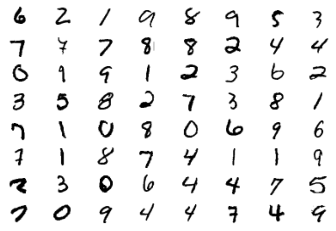

Preds:
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
Train Epoch: 7 [0/60000 (0%)]	Loss: 2.308383
Train Epoch: 7 [6400/60000 (11%)]	Loss: 2.296911
Train Epoch: 7 [12800/60000 (21%)]	Loss: 2.313267
Train Epoch: 7 [19200/60000 (32%)]	Loss: 2.308046
Train Epoch: 7 [25600/60000 (43%)]	Loss: 2.300103
Train Epoch: 7 [32000/60000 (53%)]	Loss: 2.301179
Train Epoch: 7 [38400/60000 (64%)]	Loss: 2.299992
Train Epoch: 7 [44800/60000 (75%)]	Loss: 2.297909
Train Epoch: 7 [51200/60000 (85%)]	Loss: 2.301634
Train Epoch: 7 [57600/60000 (96%)]	Loss: 2.307395

Test set: Average loss: 23010.1326, Accuracy: 1135/10000 (11%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


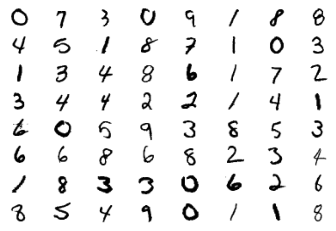

Preds:
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
Train Epoch: 8 [0/60000 (0%)]	Loss: 2.305958
Train Epoch: 8 [6400/60000 (11%)]	Loss: 2.297342
Train Epoch: 8 [12800/60000 (21%)]	Loss: 2.300409
Train Epoch: 8 [19200/60000 (32%)]	Loss: 2.314145
Train Epoch: 8 [25600/60000 (43%)]	Loss: 2.311251
Train Epoch: 8 [32000/60000 (53%)]	Loss: 2.300881
Train Epoch: 8 [38400/60000 (64%)]	Loss: 2.306387
Train Epoch: 8 [44800/60000 (75%)]	Loss: 2.303151
Train Epoch: 8 [51200/60000 (85%)]	Loss: 2.294713
Train Epoch: 8 [57600/60000 (96%)]	Loss: 2.302924

Test set: Average loss: 23010.0781, Accuracy: 1135/10000 (11%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


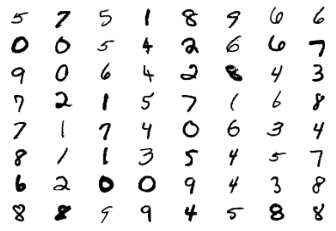

Preds:
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
Train Epoch: 9 [0/60000 (0%)]	Loss: 2.300451
Train Epoch: 9 [6400/60000 (11%)]	Loss: 2.295859
Train Epoch: 9 [12800/60000 (21%)]	Loss: 2.312506
Train Epoch: 9 [19200/60000 (32%)]	Loss: 2.303658
Train Epoch: 9 [25600/60000 (43%)]	Loss: 2.311610
Train Epoch: 9 [32000/60000 (53%)]	Loss: 2.296115
Train Epoch: 9 [38400/60000 (64%)]	Loss: 2.297035
Train Epoch: 9 [44800/60000 (75%)]	Loss: 2.301519
Train Epoch: 9 [51200/60000 (85%)]	Loss: 2.304328
Train Epoch: 9 [57600/60000 (96%)]	Loss: 2.307180

Test set: Average loss: 23010.1763, Accuracy: 1135/10000 (11%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


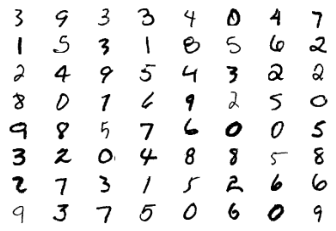

Preds:
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,
1,1,1,1,1,1,1,1,


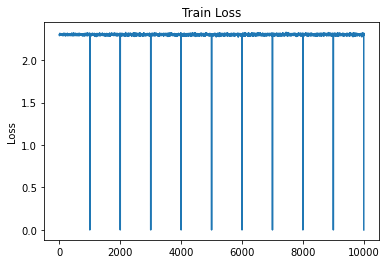

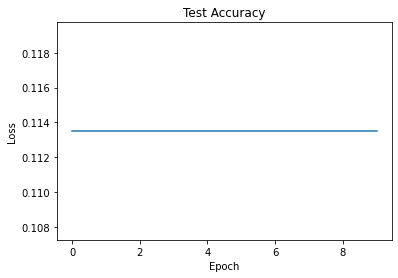

In [3]:
import itertools

import argparse
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

BATCH_SIZE = 64
TEST_BATCH_SIZE = 1000
#LEARNING_RATE = 1
LEARNING_RATE = 0.001 # CHANGED
GAMMA = 0.7
RANDOM_SEED = 1

torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda")

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True, num_workers=1, pin_memory=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=TEST_BATCH_SIZE, shuffle=True, num_workers=1, pin_memory=True)

print("#################################")
print("# Input:")

train_iter = iter(train_loader)
test_iter = iter(test_loader)
images, labels = train_iter.next()
print(f'Images is tensor of shape: {images.shape}, labels is tensor of shape: {labels.shape}')
figure = plt.figure()
num_of_images = 64
for index in range(1, num_of_images + 1):
    plt.subplot(8, 8, index)
    plt.axis('off')
    plt.imshow(images[index-1].numpy().squeeze(), cmap='gray_r')
print("Images:")
plt.show()
print("Labels:")
for i in range(8):
    for j in range(8):
        print(labels[i*8+j].item(), end=',')
    print()

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.5)
        self.dropout2 = nn.Dropout2d(1.0)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

model = Model().to(device)
#optimizer = optim.Adadelta(model.parameters(), lr=LEARNING_RATE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)  # Changed


EPOCHS = 10
ITER_PER_EPOCH = 1000
TEST_ITER_PER_EPOCH = len(test_loader)
LOG_INTERVAL = 100

print("#################################")
print("# Training:")

train_losses = []
test_accuracies = []

for epoch in range(EPOCHS):
    train_iter = itertools.cycle(iter(train_loader))
    test_iter =  iter(test_loader)
    
    train_losses_per_epoch = np.zeros(ITER_PER_EPOCH)
    for batch_idx in range(ITER_PER_EPOCH):
        (data, target) = next(train_iter)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    train_losses.append(train_losses_per_epoch.mean())
    test_loss = 0
    total = 0
    correct = 0
    images = None
    preds = None
    with torch.no_grad():
        for batch_idx in range(TEST_ITER_PER_EPOCH):
            (data, target) = next(test_iter)

            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += data.shape[0]
            images = data.cpu()
            preds = pred.cpu().numpy()
        test_accuracies.append(correct / total)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, total,
            100. * correct / total))
        
    print(f'Images is tensor of shape: {images.shape}, preds is tensor of shape: {preds.shape}')
    figure = plt.figure()
    num_of_images = 64
    for index in range(num_of_images):
        plt.subplot(8, 8, index+1)
        plt.axis('off')
        plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')
    
    print("#################################")
    print("# Test Output:")

    print("Images:")
    plt.show()
    print("Preds:")
    for i in range(8):
        for j in range(8):
            print(preds[i*8+j].item(), end=',')
        print()
plt.plot(train_losses)
plt.ylabel('Loss')
plt.title('Train Loss')
plt.show()

plt.plot(test_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Accuracy')
plt.show()

## Decreasing Dropout
Test accuracy improves slightly. Maybe there was too much Dropout added initially?

#################################
# Input:
Images is tensor of shape: torch.Size([64, 1, 28, 28]), labels is tensor of shape: torch.Size([64])
Images:


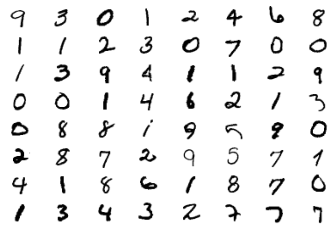

Labels:
9,3,0,1,2,4,6,8,
1,1,2,3,0,7,0,0,
1,3,9,4,1,1,2,9,
0,0,1,4,6,2,1,3,
0,8,8,1,9,5,9,0,
2,8,7,2,9,5,7,1,
4,1,8,6,1,8,7,0,
1,3,4,3,2,7,7,7,
#################################
# Training:
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.310136
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.241013
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.137840
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.103614
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.029501
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.116701
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.075613
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.178135
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.126878
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.119994

Test set: Average loss: 612.5343, Accuracy: 9805/10000 (98%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


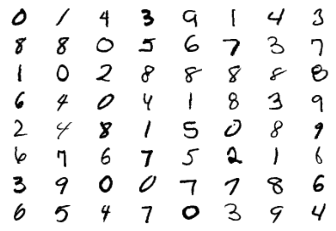

Preds:
0,1,4,3,9,1,4,3,
8,8,0,5,6,7,3,7,
1,0,2,8,8,8,8,8,
6,4,0,4,1,8,3,9,
2,4,8,1,5,0,8,9,
6,7,6,7,5,2,1,6,
3,9,0,0,7,7,8,6,
8,5,4,7,0,3,9,4,
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.014526
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.007582
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.016135
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.038466
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.034840
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.089180
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.030826
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.006160
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.013367
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.039169

Test set: Average loss: 473.3594, Accuracy: 9845/10000 (98%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


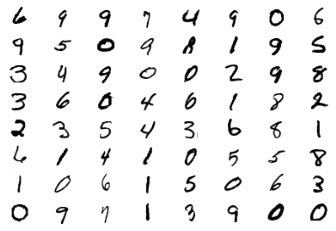

Preds:
6,9,9,7,4,9,0,6,
9,5,0,9,8,1,9,5,
3,4,9,0,0,2,9,8,
3,6,0,4,6,1,8,2,
2,3,5,4,3,6,8,1,
6,1,4,1,0,5,5,8,
1,0,6,1,5,0,6,3,
0,9,7,1,3,9,0,0,
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.003105
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.068315
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.009844
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.031931
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.024358
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.115106
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.014225
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.063391
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.035539
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.023767

Test set: Average loss: 512.6331, Accuracy: 9849/10000 (98%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


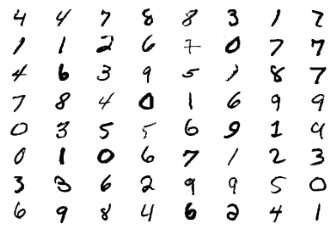

Preds:
4,4,7,8,8,3,1,7,
1,1,2,6,7,0,7,7,
4,6,3,9,5,1,8,7,
7,8,4,0,1,6,9,9,
0,3,5,5,6,9,1,4,
0,1,0,6,7,1,2,3,
3,3,6,2,9,9,5,0,
6,9,8,4,6,2,4,1,
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.019837
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.053523
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.067479
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.031891
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.068375
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.007053
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.007253
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.003207
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.001960
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.019206

Test set: Average loss: 466.0442, Accuracy: 9853/10000 (99%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


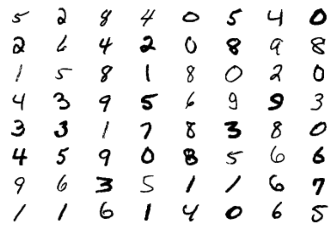

Preds:
5,2,8,4,0,5,4,0,
2,6,4,2,0,8,9,8,
1,5,8,1,8,0,2,0,
4,3,9,5,6,9,9,3,
3,3,1,7,8,3,8,0,
4,5,9,0,8,5,6,6,
9,6,3,5,1,1,6,7,
1,1,6,1,4,0,6,5,
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.022771
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.000882
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.117632
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.151072
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.047721
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.008114
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.024468
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.040209
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.004006
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.000750

Test set: Average loss: 483.2685, Accuracy: 9862/10000 (99%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


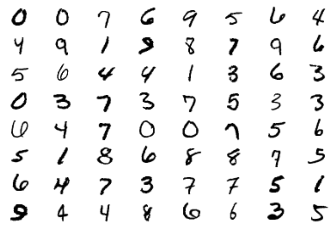

Preds:
0,0,7,6,9,5,6,4,
4,9,1,7,8,7,9,6,
5,6,4,4,1,3,6,3,
0,3,7,3,7,5,3,3,
0,4,7,0,0,7,5,6,
5,1,8,6,8,8,7,5,
6,4,7,3,7,7,5,1,
9,4,4,8,6,6,3,5,
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.001764
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.005375
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.001142
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.000372
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.007112
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.000828
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.247841
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.106708
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.002181
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.000349

Test set: Average loss: 501.6314, Accuracy: 9872/10000 (99%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


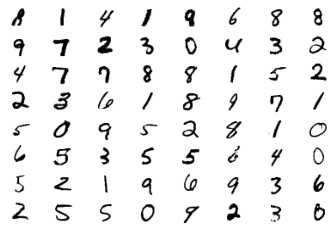

Preds:
8,1,4,1,9,6,8,8,
9,7,2,3,0,4,3,2,
4,7,7,8,8,1,5,2,
2,3,6,1,8,9,7,1,
5,0,9,5,2,8,1,0,
6,5,3,5,5,6,4,0,
5,2,1,9,6,9,3,6,
2,5,5,0,9,2,3,0,
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.022082
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.000444
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.000194
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.006493
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.037268
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.004728
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.014741
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.001870
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.001997
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.001498

Test set: Average loss: 563.2009, Accuracy: 9876/10000 (99%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


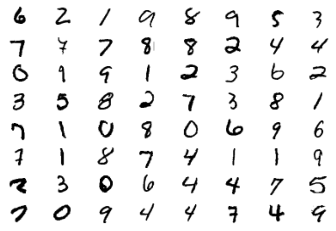

Preds:
6,2,1,9,8,9,5,3,
7,7,7,8,8,2,4,4,
0,9,9,1,2,3,6,2,
3,5,8,2,7,3,8,1,
7,1,0,8,0,6,9,6,
7,1,8,7,4,1,1,9,
7,3,0,6,4,4,7,5,
7,0,9,4,4,7,4,9,
Train Epoch: 7 [0/60000 (0%)]	Loss: 0.000442
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.000252
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.000597
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.000495
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.003375
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.018040
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.070825
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.004834
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.000162
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.005316

Test set: Average loss: 575.5207, Accuracy: 9863/10000 (99%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


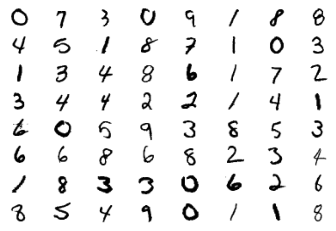

Preds:
0,7,3,0,9,1,8,8,
4,5,1,8,7,1,0,3,
1,3,4,8,6,1,7,2,
3,4,4,2,2,1,4,1,
6,0,5,9,3,8,5,3,
6,6,8,6,8,2,3,4,
1,8,3,3,0,6,2,6,
8,5,4,9,0,1,1,8,
Train Epoch: 8 [0/60000 (0%)]	Loss: 0.024340
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.005978
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.009895
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.002131
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.000954
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.003377
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.090476
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.002973
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.053297
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.004289

Test set: Average loss: 574.4026, Accuracy: 9864/10000 (99%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


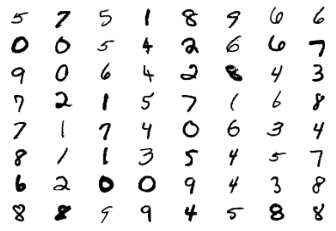

Preds:
5,7,5,1,8,9,6,6,
0,0,5,4,2,6,6,7,
9,0,6,4,2,3,4,3,
7,2,1,5,7,1,6,8,
7,1,7,4,0,6,3,4,
8,1,1,3,5,4,5,7,
6,2,0,0,9,4,3,8,
8,8,9,9,4,5,8,8,
Train Epoch: 9 [0/60000 (0%)]	Loss: 0.000245
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.000285
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.000064
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.001715
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.019316
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.002435
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.003133
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.010885
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.001615
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.033369

Test set: Average loss: 600.8859, Accuracy: 9869/10000 (99%)

Images is tensor of shape: torch.Size([1000, 1, 28, 28]), preds is tensor of shape: (1000, 1)
#################################
# Test Output:
Images:


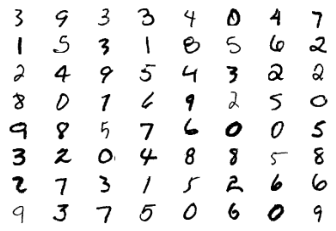

Preds:
3,9,3,3,4,0,4,7,
1,5,3,1,8,5,6,2,
2,4,9,5,4,3,2,2,
8,0,7,6,9,2,5,0,
9,8,5,7,6,0,0,5,
3,2,0,4,8,8,5,8,
2,7,3,1,5,2,6,6,
9,3,7,5,0,6,0,9,


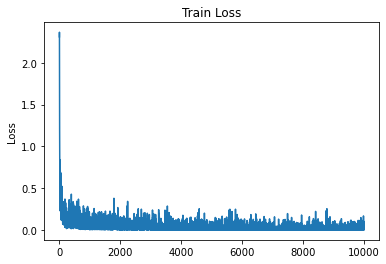

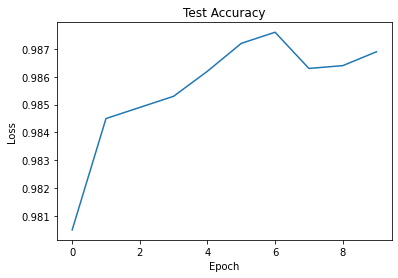

In [4]:
import itertools

import argparse
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

BATCH_SIZE = 64
TEST_BATCH_SIZE = 1000
#LEARNING_RATE = 1
LEARNING_RATE = 0.001 # CHANGED
GAMMA = 0.7
RANDOM_SEED = 1

torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda")

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True, num_workers=1, pin_memory=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=TEST_BATCH_SIZE, shuffle=True, num_workers=1, pin_memory=True)

print("#################################")
print("# Input:")

train_iter = iter(train_loader)
test_iter = iter(test_loader)
images, labels = train_iter.next()
print(f'Images is tensor of shape: {images.shape}, labels is tensor of shape: {labels.shape}')
figure = plt.figure()
num_of_images = 64
for index in range(1, num_of_images + 1):
    plt.subplot(8, 8, index)
    plt.axis('off')
    plt.imshow(images[index-1].numpy().squeeze(), cmap='gray_r')
print("Images:")
plt.show()
print("Labels:")
for i in range(8):
    for j in range(8):
        print(labels[i*8+j].item(), end=',')
    print()

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.125)
        self.dropout2 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

model = Model().to(device)
#optimizer = optim.Adadelta(model.parameters(), lr=LEARNING_RATE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)  # Changed


EPOCHS = 10
ITER_PER_EPOCH = 1000
TEST_ITER_PER_EPOCH = len(test_loader)
LOG_INTERVAL = 100

print("#################################")
print("# Training:")

train_losses = []
test_accuracies = []

for epoch in range(EPOCHS):
    train_iter = itertools.cycle(iter(train_loader))
    test_iter =  iter(test_loader)
    
    train_losses_per_epoch = np.zeros(ITER_PER_EPOCH)
    for batch_idx in range(ITER_PER_EPOCH):
        (data, target) = next(train_iter)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    train_losses.append(train_losses_per_epoch.mean())
    test_loss = 0
    total = 0
    correct = 0
    images = None
    preds = None
    with torch.no_grad():
        for batch_idx in range(TEST_ITER_PER_EPOCH):
            (data, target) = next(test_iter)

            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += data.shape[0]
            images = data.cpu()
            preds = pred.cpu().numpy()
        test_accuracies.append(correct / total)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, total,
            100. * correct / total))
        
    print(f'Images is tensor of shape: {images.shape}, preds is tensor of shape: {preds.shape}')
    figure = plt.figure()
    num_of_images = 64
    for index in range(num_of_images):
        plt.subplot(8, 8, index+1)
        plt.axis('off')
        plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')
    
    print("#################################")
    print("# Test Output:")

    print("Images:")
    plt.show()
    print("Preds:")
    for i in range(8):
        for j in range(8):
            print(preds[i*8+j].item(), end=',')
        print()
plt.plot(train_losses)
plt.ylabel('Loss')
plt.title('Train Loss')
plt.show()

plt.plot(test_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Accuracy')
plt.show()